# Getting the tools ready

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split
from IPython.display import Image
import tensorflow as tf
import tensorflow_hub as hub
import os
import datetime

# Make the data ready

In [0]:
# Read Csv

label_file = pd.read_csv('drive/My Drive/Dog-vision/labels.csv')

# Seperate names for the labels.

filename = ['drive/My Drive/Dog-vision/train/' + fname + '.jpg' for fname in label_file['id']]

# Converting the strings into the arays.

label = label_file['breed'].to_numpy()

#Unique breeds of the categories
unique_breed = np.unique(label)

In [0]:
boolean_label = [label == unique_breed for label in label]

In [0]:
X = filename
y = boolean_label

In [0]:
NUM_IMAGES = 1000
np.random.seed(42)
X_train,X_valid,y_train,y_valid = train_test_split(X[:NUM_IMAGES],y[:NUM_IMAGES],test_size=0.2,random_state=42)

# Process the image into tensors

In [0]:
IMG_SIZE = 224
def process_image(image_path,img_size = IMG_SIZE):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])
  return image

def create_image_tuple(image_path,label):
  image = process_image(image_path)
  return image,label

## Create batches for the train data,test data as well as validation data.

In [0]:
BATCH_SIZE = 32

def create_batches(X,y=False,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  if test_data:
    print("Creating batches of testing data...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print('Creating batches for validation data...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(create_image_tuple).batch(BATCH_SIZE)
    return data_batch
  else:
    print('Creating batches for train data...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(create_image_tuple).batch(BATCH_SIZE)
  return data_batch

## Divide whole data into training and validation data.

In [0]:
train_data = create_batches(X_train,y_train)
valid_data = create_batches(X_valid,y_valid,valid_data=True)

Creating batches for train data...
Creating batches for validation data...


In [0]:
train_images,train_labels = next(train_data.as_numpy_iterator())

## Let's visualize data.

In [0]:
def show_images(images,labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_breed[labels[i].argmax()])
    plt.axis('off')

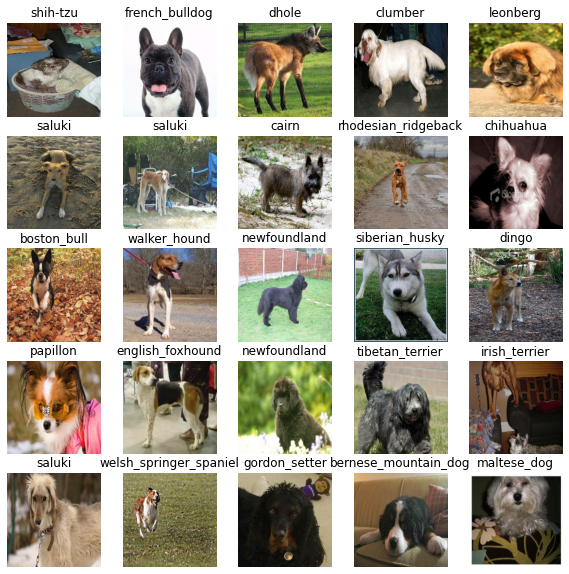

In [0]:
show_images(train_images,train_labels)

## Okay now lets build the model

In [0]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] #Batch,height,width,color channels.
OUTPUT_SHAPE = len(unique_breed) #length of all dog labels.
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4' #HUB url

In [0]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):

  model = tf.keras.Sequential([
                               hub.KerasLayer(MODEL_URL), #Layer1
                               tf.keras.layers.Dense(activation='softmax',units=OUTPUT_SHAPE)]) #Layer2

  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy'])
  
  model.build(INPUT_SHAPE)

  return model


In [0]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


### Lets create two callbacks for out model .

1.Tensorboard callback => Saves the logs of the train and valid data over the metrics provided.

2.Early stopping => Stops the iteration of data , If the metrics data gets overfitted into the model

In [0]:
%load_ext tensorboard
def create_tensorboard_callbacks():
  logdir = os.path.join('drive/My Drive/Dog-vision/logs',datetime.datetime.now().strftime('%Y%m%d - %H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

## Train our model

In [0]:
#Epochs are the iteration of the data provided to the model.

NUM_EPOCS = 100 #@param {type:'slider',min:10,max:1000} 

In [0]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callbacks()
  model.fit(x=train_data,
            epochs=NUM_EPOCS,
            validation_freq=1,
            validation_data=valid_data,
            callbacks=[tensorboard,early_stopping])
  return model

## Lets gooooo

In [0]:
model = train_model()

Epoch 1/100
25/25 [==============================] - 517s 21s/step - loss: 4.6422 - accuracy: 0.1050 - val_loss: 3.4127 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 5s 188ms/step - loss: 1.6685 - accuracy: 0.6737 - val_loss: 2.2131 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 5s 186ms/step - loss: 0.5795 - accuracy: 0.9362 - val_loss: 1.7319 - val_accuracy: 0.5550
Epoch 4/100
25/25 [==============================] - 5s 187ms/step - loss: 0.2548 - accuracy: 0.9925 - val_loss: 1.5396 - val_accuracy: 0.6100
Epoch 5/100
25/25 [==============================] - 5s 187ms/step - loss: 0.1466 - accuracy: 0.9975 - val_loss: 1.4526 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 5s 187ms/step - loss: 0.1018 - accuracy: 1.0000 - val_loss: 1.4076 - val_accuracy: 0.6350
Epoch 7/100
25/25 [==============================] - 5s 187ms/step - loss: 0.0755 - accuracy: 0.9987 - val_loss: 1.3706 - val_accuracy: 0.6550

# Making and evaluating predictions:

In [0]:
prediction = model.predict(valid_data,verbose=1)

7/7 [==============================] - 1s 116ms/step


In [0]:
def get_pred_label(prediction_probabilities):
  '''
  Turns an array of prediction probailities into labels
  '''
  return unique_breed[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(prediction[81])
pred_label


'dingo'

In [0]:
def unbatchify(data):
  images = []
  labels = []
  for label , image in data.unbatch().as_numpy_iterator():
    images.append(label)
    labels.append(image)
  return images,labels
val_images,val_labels = unbatchify(valid_data)
val_images[0],val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

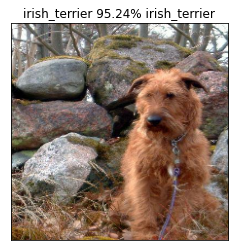

In [0]:
def plot_pred(prediction_probabilities,labels,images,n=95):
  pred_prob , true_label , image = prediction_probabilities[n] , unique_breed[np.argmax(labels[n])] , images[n]

  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.title("{} {:0.2f}% {}".format(pred_label, np.max(pred_prob)*100,true_label))
plot_pred(prediction_probabilities=prediction,labels=val_labels,images=val_images)

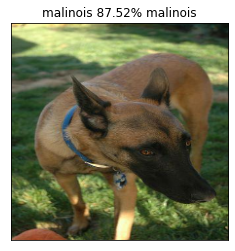

In [0]:
plot_pred(prediction_probabilities=prediction,labels=val_labels,images=val_images,n=78)

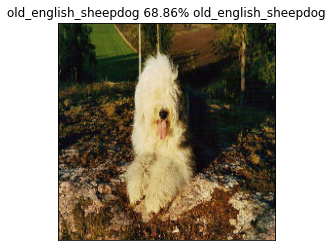

In [0]:
plot_pred(prediction_probabilities=prediction,labels=val_labels,images=val_images,n=7)

In [0]:
def plot_pred_conf(prediction_probabilities,labels,n=1):
  pred_prob , true_label = prediction_probabilities[n] , labels[n]

  pred_label = get_pred_label(pred_prob)
  #top 10 confidences indexes
  top_10_pred_indexes = pred_prob.argsort()[:10][::-1]

  #top 10 conf values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  #Top 10 pred labels
  top_10_pred_labels = unique_breed[top_10_pred_indexes]


  #Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = 'grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = 'vertical')
  if np.isin(true_label.all(),top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_labels)].set_color=('salmon')
  else:
    pass

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


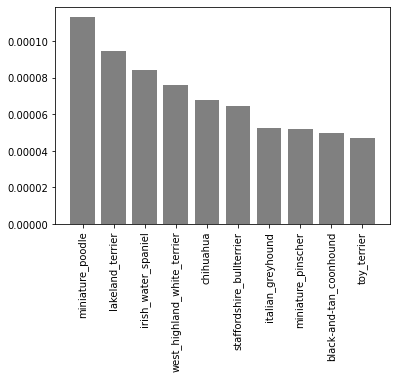

In [0]:
plot_pred_conf(prediction_probabilities=prediction,labels=val_labels,n=8)

In [0]:
def save_model(model,suffix=None):
  modeldir = os.path.join('drive/My Drive/Dog-vision/Savedmodel',
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  model_path = modeldir + '-' + suffix + '.h5'
  print(f'Saving model to :{model_path}...')
  model.save(model_path)
  return model_path

In [0]:
def load_model(model_path):
  print(f'Loading saved model from {model_path}...')
  model = tf.keras.models.load_model(model_path,custom_objects={'KerasLayer':hub.KerasLayer})
  return model

In [0]:
save_model(model,suffix='100-images-mobilenet')

Saving model to :drive/My Drive/Dog-vision/Savedmodel/20200529-110249-100-images-mobilenet.h5...


'drive/My Drive/Dog-vision/Savedmodel/20200529-110249-100-images-mobilenet.h5'

In [0]:
Loaded_100_images = load_model('drive/My Drive/Dog-vision/Savedmodel/20200528-042613-100-images-mobilenet.h5')

Loading saved model from drive/My Drive/Dog-vision/Savedmodel/20200528-042613-100-images-mobilenet.h5...


In [0]:
model.evaluate(valid_data)

7/7 [==============================] - 1s 116ms/step - loss: 1.2719 - accuracy: 0.6600


[1.2718769311904907, 0.6600000262260437]

In [0]:
Loaded_100_images.evaluate(valid_data)

7/7 [==============================] - 1s 116ms/step - loss: 1.2567 - accuracy: 0.6600


[1.2567042112350464, 0.6600000262260437]

## Training the full data!

In [0]:
full_data = create_batches(X,y,test_data=False,valid_data=False)

Creating batches for train data...


In [0]:
full_data
full_model = create_model()

In [0]:
full_model_tensorboard_callback = create_tensorboard_callbacks()
full_model_earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=3) 

In [0]:
full_model.fit(x=full_data,callbacks=[full_model_earlystopping_callback,full_model_tensorboard_callback],epochs=NUM_EPOCS)

Epoch 1/100
320/320 [==============================] - 5804s 18s/step - loss: 1.3116 - accuracy: 0.6717
Epoch 2/100
320/320 [==============================] - 47s 147ms/step - loss: 0.3988 - accuracy: 0.8814
Epoch 3/100
320/320 [==============================] - 46s 145ms/step - loss: 0.2378 - accuracy: 0.9350
Epoch 4/100
320/320 [==============================] - 47s 146ms/step - loss: 0.1508 - accuracy: 0.9658
Epoch 5/100
320/320 [==============================] - 47s 147ms/step - loss: 0.1061 - accuracy: 0.9789
Epoch 6/100
320/320 [==============================] - 48s 149ms/step - loss: 0.0766 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 47s 148ms/step - loss: 0.0581 - accuracy: 0.9929
Epoch 8/100
320/320 [==============================] - 47s 146ms/step - loss: 0.0456 - accuracy: 0.9938
Epoch 9/100
320/320 [==============================] - 47s 147ms/step - loss: 0.0374 - accuracy: 0.9961
Epoch 10/100
320/320 [==============================] - 48s 151m

In [0]:
save_model(full_model,suffix='full_model_mobilenet')

Saving model to :drive/My Drive/Dog-vision/Savedmodel/20200529-125355-full_model_mobiilent.h5...


'drive/My Drive/Dog-vision/Savedmodel/20200529-125355-full_model_mobiilent.h5'

In [0]:
loaded_full_model = load_model('drive/My Drive/Dog-vision/Savedmodel/20200529-125355-full_model_mobiilent.h5')

Loading saved model from drive/My Drive/Dog-vision/Savedmodel/20200529-125355-full_model_mobiilent.h5...


In [0]:
test_path = 'drive/My Drive/Dog-vision/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog-vision/test/ef0209bcfab48f72f71c9d1b8648aa45.jpg',
 'drive/My Drive/Dog-vision/test/ead86e148dabfcc4ef7f4dcdce9fcf57.jpg',
 'drive/My Drive/Dog-vision/test/efe3a7327992dafcaf30dc3bfae29473.jpg',
 'drive/My Drive/Dog-vision/test/ea1f200df74cd6c6a458436eedabbc8d.jpg',
 'drive/My Drive/Dog-vision/test/ec9a95ba1bab38eeff6b6aa40d5f4edf.jpg',
 'drive/My Drive/Dog-vision/test/f3e898913d681b7d938a298f9e068254.jpg',
 'drive/My Drive/Dog-vision/test/f157256196b2c6e28a739d2947e956e5.jpg',
 'drive/My Drive/Dog-vision/test/f1167eabf53759dad015f0abb813a451.jpg',
 'drive/My Drive/Dog-vision/test/e95640aaa10c9ad1c6e27a175c04511b.jpg',
 'drive/My Drive/Dog-vision/test/ef119ef06b97f22d32dbd5cfc08bf60c.jpg']

In [0]:
test_data = create_batches(test_filenames,test_data = True)

Creating batches of testing data...


In [0]:
prediction = loaded_full_model.predict(test_data,verbose=1)

324/324 [==============================] - 3601s 11s/step


In [0]:
prediction


array([[1.5134736e-09, 2.1214507e-08, 2.3677958e-12, ..., 7.0284556e-11,
        4.6055507e-11, 5.6948052e-10],
       [4.5410466e-06, 4.3709963e-07, 8.4576584e-08, ..., 1.0339716e-07,
        1.4785087e-02, 3.4391907e-09],
       [6.0346818e-11, 4.8396016e-09, 9.0085659e-13, ..., 3.9363017e-13,
        5.2655231e-14, 1.1350985e-12],
       ...,
       [2.7649389e-09, 1.4624274e-07, 5.6232824e-07, ..., 7.6867565e-08,
        5.8696304e-13, 5.1094740e-10],
       [1.1955223e-08, 1.4084003e-07, 1.1993834e-06, ..., 4.6765991e-10,
        4.2902712e-07, 3.4148050e-07],
       [3.0331795e-10, 1.2499297e-10, 9.8578967e-10, ..., 2.0841223e-11,
        5.0714135e-09, 9.9905950e-01]], dtype=float32)

In [0]:
np.savetxt('drive/My Drive/Dog-vision/prediction_array.csv',prediction,delimiter=',')

In [0]:
test_predictions = np.loadtxt('drive/My Drive/Dog-vision/prediction_array.csv',delimiter=',')

In [0]:
test_predictions.shape

(10357, 120)

In [0]:
pred_df = pd.DataFrame(columns=['id'] + list(unique_breed))
pred_df.head(10)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [0]:
test_ids = [os.path.splitext(path) for path in os.listdir(test_path)]
test_ids

[('ef0209bcfab48f72f71c9d1b8648aa45', '.jpg'),
 ('ead86e148dabfcc4ef7f4dcdce9fcf57', '.jpg'),
 ('efe3a7327992dafcaf30dc3bfae29473', '.jpg'),
 ('ea1f200df74cd6c6a458436eedabbc8d', '.jpg'),
 ('ec9a95ba1bab38eeff6b6aa40d5f4edf', '.jpg'),
 ('f3e898913d681b7d938a298f9e068254', '.jpg'),
 ('f157256196b2c6e28a739d2947e956e5', '.jpg'),
 ('f1167eabf53759dad015f0abb813a451', '.jpg'),
 ('e95640aaa10c9ad1c6e27a175c04511b', '.jpg'),
 ('ef119ef06b97f22d32dbd5cfc08bf60c', '.jpg'),
 ('eebf49093e7b0c603ee4c8d67d061352', '.jpg'),
 ('efac70ee513c40265966b89d715f183e', '.jpg'),
 ('f050fe5feb0a81de5da10a5e806e739a', '.jpg'),
 ('f0138bdbeba02c23bef5eebd81fcf3ec', '.jpg'),
 ('ea54171754dc00a910fd4ed0cb41e765', '.jpg'),
 ('f374a9d5a46f8b8aa97c715768f170d4', '.jpg'),
 ('f31bfb17e3d1800493376fffd77fed72', '.jpg'),
 ('f30f7155fd94e7f0d3621d9cc9031e93', '.jpg'),
 ('f4fa65b062607d69c98f16cb625d5915', '.jpg'),
 ('fde6a7af1944348eb4ecd1268f49a549', '.jpg'),
 ('f7f585083fb639c3bfced127e2cd0046', '.jpg'),
 ('f85c38afe1

In [0]:
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids

['ef0209bcfab48f72f71c9d1b8648aa45',
 'ead86e148dabfcc4ef7f4dcdce9fcf57',
 'efe3a7327992dafcaf30dc3bfae29473',
 'ea1f200df74cd6c6a458436eedabbc8d',
 'ec9a95ba1bab38eeff6b6aa40d5f4edf',
 'f3e898913d681b7d938a298f9e068254',
 'f157256196b2c6e28a739d2947e956e5',
 'f1167eabf53759dad015f0abb813a451',
 'e95640aaa10c9ad1c6e27a175c04511b',
 'ef119ef06b97f22d32dbd5cfc08bf60c',
 'eebf49093e7b0c603ee4c8d67d061352',
 'efac70ee513c40265966b89d715f183e',
 'f050fe5feb0a81de5da10a5e806e739a',
 'f0138bdbeba02c23bef5eebd81fcf3ec',
 'ea54171754dc00a910fd4ed0cb41e765',
 'f374a9d5a46f8b8aa97c715768f170d4',
 'f31bfb17e3d1800493376fffd77fed72',
 'f30f7155fd94e7f0d3621d9cc9031e93',
 'f4fa65b062607d69c98f16cb625d5915',
 'fde6a7af1944348eb4ecd1268f49a549',
 'f7f585083fb639c3bfced127e2cd0046',
 'f85c38afe1945e2c1f70009c2da2b770',
 'f8c3fb7b00c96ba6881125d7ab0f7bf9',
 'ff357aadc868c7b38e17bd5b87de31be',
 'f8f3c8903f904242b099f1fa4472ff02',
 'ff20371d584e330e288f9a863f484ca5',
 'f6e209dbbd97aadf518f16d18a807ffb',
 

In [0]:
pred_df['id'] = test_ids

In [0]:
pred_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,ef0209bcfab48f72f71c9d1b8648aa45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ead86e148dabfcc4ef7f4dcdce9fcf57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,efe3a7327992dafcaf30dc3bfae29473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ea1f200df74cd6c6a458436eedabbc8d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec9a95ba1bab38eeff6b6aa40d5f4edf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
pred_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,ef0209bcfab48f72f71c9d1b8648aa45,1.51347e-09,2.12145e-08,2.3678e-12,1.45506e-11,4.94047e-10,5.07385e-08,6.08034e-09,5.31148e-11,1.10439e-13,3.08804e-12,1.23269e-12,1.18019e-06,2.82285e-10,1.52169e-08,4.96014e-11,1.17462e-08,0.989529,6.00303e-11,1.33487e-05,5.35927e-09,2.1462e-13,6.81918e-12,1.14345e-11,9.65727e-10,1.32739e-09,8.41492e-10,5.13658e-11,1.13e-07,6.66066e-12,8.33063e-10,1.84404e-09,5.32208e-10,9.52397e-07,0.0104368,2.80926e-13,1.549e-13,6.58806e-10,8.06526e-14,1.24113e-10,...,3.03048e-13,4.29405e-11,1.30211e-09,3.40216e-09,4.45654e-06,1.53254e-07,1.83565e-09,2.92097e-08,2.26131e-11,1.27718e-09,6.01457e-11,1.0322e-10,5.10895e-10,4.81813e-07,3.61637e-08,3.55791e-09,1.14433e-09,1.72713e-10,1.55187e-12,2.39846e-06,1.80861e-10,7.54421e-09,8.33147e-10,5.96516e-13,2.39887e-09,1.23568e-11,3.22396e-10,6.90716e-10,1.65679e-08,8.9211e-09,5.51397e-10,2.7101e-09,3.34664e-11,4.09926e-08,5.15824e-12,1.03072e-10,6.92638e-09,7.02846e-11,4.60555e-11,5.69481e-10
1,ead86e148dabfcc4ef7f4dcdce9fcf57,4.54105e-06,4.371e-07,8.45766e-08,0.00133041,1.14244e-07,3.0386e-07,2.24499e-10,3.89451e-08,1.53512e-08,2.76386e-10,0.000710693,1.14719e-07,5.16358e-09,7.57349e-08,1.00043e-09,9.55815e-08,1.92664e-08,3.60804e-05,8.94065e-09,4.81862e-11,0.000196011,1.50319e-08,6.39136e-07,6.88425e-06,3.3997e-08,5.8251e-07,2.48915e-07,1.01705e-10,5.55937e-08,3.78555e-10,4.6672e-07,7.10087e-08,4.9649e-08,6.35944e-09,5.74745e-08,7.33721e-07,2.8443e-09,1.88618e-08,1.43353e-10,...,8.02566e-09,2.69868e-11,3.47127e-07,1.32137e-09,2.67365e-08,6.19344e-07,3.21702e-09,1.12948e-07,2.47736e-08,1.03183e-08,8.46331e-08,4.74729e-09,2.58906e-09,1.26443e-11,2.26624e-09,1.00914e-05,1.33969e-05,8.60694e-06,4.70485e-05,5.30555e-09,3.64105e-10,1.62491e-08,1.12841e-08,9.48212e-07,1.80742e-05,0.00100615,6.00478e-06,4.65572e-08,3.21939e-09,6.69995e-07,5.06023e-06,1.91986e-09,8.70306e-09,8.41333e-09,1.63694e-09,6.53021e-09,8.74236e-11,1.03397e-07,0.0147851,3.43919e-09
2,efe3a7327992dafcaf30dc3bfae29473,6.03468e-11,4.8396e-09,9.00857e-13,7.14125e-10,1.11583e-09,1.07385e-11,2.18999e-12,7.95265e-14,2.81526e-12,5.6254e-12,5.57277e-11,2.94964e-11,1.81525e-12,7.19388e-09,2.04762e-08,2.01261e-11,9.85413e-11,8.60577e-10,7.49331e-12,1.97839e-12,5.28838e-11,3.19235e-08,1.62566e-08,1.98267e-09,1.89587e-10,4.41779e-06,4.28535e-14,6.30762e-13,9.97115e-11,1.68677e-11,3.74762e-08,1.51919e-08,8.9668e-11,1.16942e-10,4.91592e-13,1.87813e-10,3.35959e-11,1.20173e-11,1.59752e-10,...,8.77002e-11,5.04639e-09,5.80582e-13,7.63911e-10,5.49087e-10,3.83843e-06,3.42374e-13,9.98559e-12,2.83027e-09,1.06161e-10,1.46449e-10,2.74509e-08,3.68179e-08,2.16879e-11,7.40895e-12,6.02225e-10,1.29316e-14,1.05063e-11,4.10474e-11,4.31837e-11,3.6083e-10,2.60469e-12,2.03826e-10,2.27443e-13,3.59338e-12,1.78674e-10,1.43099e-12,2.22571e-07,1.00755e-06,6.3411e-12,8.19624e-12,3.55265e-12,5.72329e-13,5.5115e-11,8.57554e-12,8.95614e-13,2.46546e-15

In [0]:
pred_df.to_csv('drive/My Drive/Dog-vision/final_Submissions.csv',index=False)